# Integrate resources to replicate hetionet (AlzKB)

In [2]:
#pip install hetio

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas
import seaborn

import hetio.hetnet
import hetio.readwrite
import hetio.stats

#from utils import rawgit, obo_iri
def obo_iri(identifier):
    return 'http://purl.obolibrary.org/obo/' + identifier.replace(':', '_')

/opt/anaconda3/lib/python3.9/site-packages/hetio/__init__.py:11: FutureWarning: 
PACKAGE HAS BEEN RELOCATED:
v0.2.11 is the last release before the hetio package is renamed to hetnetpy.
Consider switching to the hetnetpy package or specifying hetio<=0.2.10 to silence this warning.
Future releases and development will only occur for the hetnetpy package.

  warnings.warn(message, FutureWarning)


## Define the metagraph and instantiate the graph

In [2]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Disease': 'D',
    'Gene': 'G',
    'Anatomy': 'A',
    'Symptom': 'S',
    #'Side Effect': 'SE',
    #'Pathway': 'PW',
    'Pharmacologic Class': 'PC',
    'Biological Process': 'BP',
    'Cellular Component': 'CC',
    'Molecular Function': 'MF',
    
    # metaedges
    'treats': 't',
    'palliates': 'p',
    'binds': 'b',
    'expresses': 'e',
    'regulates': 'r',
    'upregulates': 'u',
    'downregulates': 'd',
    'interacts': 'i',
    'includes': 'i',
    'covaries': 'c',
    'regulates': 'r',
    'participates': 'p',
    'resembles': 'r',
    'associates': 'a',
    'localizes': 'l',
    'presents': 'p',
    'causes': 'c',
}

metaedge_tuples = [ #only those we're updating this time
    #('Compound', 'Disease', 'treats', 'both'),
    #('Compound', 'Disease', 'palliates', 'both'),
    ('Compound', 'Gene', 'binds', 'both'),
    #('Compound', 'Gene', 'upregulates', 'both'),
    #('Compound', 'Gene', 'downregulates', 'both'),
    #('Compound', 'Compound', 'resembles', 'both'),
    #('Compound', 'Side Effect', 'causes', 'both'),
    ('Pharmacologic Class', 'Compound', 'includes', 'both'),
    #('Anatomy', 'Gene', 'expresses', 'both'),
    #('Anatomy', 'Gene', 'upregulates', 'both'),
    #('Anatomy', 'Gene', 'downregulates', 'both'),
    #('Gene', 'Gene', 'interacts', 'both'),
    #('Gene', 'Gene', 'covaries', 'both'),
    #('Gene', 'Gene', 'regulates', 'forward'),
    #('Gene', 'Pathway', 'participates', 'both'),
    ('Gene', 'Biological Process', 'participates', 'both'),
    ('Gene', 'Cellular Component', 'participates', 'both'),
    ('Gene', 'Molecular Function', 'participates', 'both'),
    ('Disease', 'Disease', 'resembles', 'both'),
    #('Disease', 'Gene', 'associates', 'both'),
    #('Disease', 'Gene', 'upregulates', 'both'),
    #('Disease', 'Gene', 'downregulates', 'both'),
    ('Disease', 'Anatomy', 'localizes', 'both'),
    ('Disease', 'Symptom', 'presents', 'both'),
]
metagraph = hetio.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetio.hetnet.Graph(metagraph)

In [3]:
import os
path ='../data'

## Gene Nodes

In [4]:
url = os.path.join(path, 'EntrezGene/genes-human.tsv')
gene_df = pandas.read_table(url)
gene_df = gene_df[gene_df.type_of_gene == 'protein-coding']
coding_genes = set(gene_df.GeneID)
gene_df.head(2)

,tax_id,GeneID,Symbol,chromosome,map_location,type_of_gene,description
0,9606,1,A1BG,19,19q13.43,protein-coding,alpha-1-B glycoprotein
1,9606,2,A2M,12,12p13.31,protein-coding,alpha-2-macroglobulin


In [5]:
for i, row in gene_df.iterrows():
    if row.type_of_gene != 'protein-coding':
        continue
    data = {
        'description': row['description'],
        'source': 'Entrez Gene',
        'url': 'http://identifiers.org/ncbigene/{}'.format(row.GeneID),
        'license': 'CC0 1.0',
    }
    if pandas.notnull(row['chromosome']):
        data['chromosome'] = row['chromosome']
    graph.add_node(kind = 'Gene', identifier=row.GeneID, name=row.Symbol, data=data)

## Disease Nodes

In [6]:
url = os.path.join(path, 'DiseaseOntology/slim-terms.tsv')
disease_df = pandas.read_table(url)
disease_df.head(2)

,doid,name,source,pathophysiology
0,DOID:2531,hematologic cancer,DOcancerslim,neoplastic
1,DOID:1319,brain cancer,DOcancerslim,neoplastic


In [7]:
for i, row in disease_df.iterrows():
    data = {
        'source': 'Disease Ontology',
        'url': obo_iri(row.doid),
        'license': 'CC BY 3.0',
    }
    graph.add_node(kind='Disease', identifier=row.doid, name=row['name'], data=data)

## Compound Nodes

In [8]:
url = os.path.join(path, 'DrugBank/drugbank-slim.tsv')
compound_df = pandas.read_table(url)
compound_df.head(2)

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi,description
0,DB00006,Bivalirudin,small molecule,approved|investigational,B01AE06,"Amino Acids, Peptides, and Proteins|Anticoagul...",OIRCOABEOLEUMC-GEJPAHFPSA-N,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,Bivalirudin is a synthetic 20 residue peptide ...
1,DB00007,Leuprolide,small molecule,approved|investigational,L02AE51|L02AE02,Adrenal Cortex Hormones|Agents Causing Muscle ...,GFIJNRVAKGFPGQ-LIJARHBVSA-N,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,Leuprolide is a synthetic 9-residue peptide an...


In [9]:
for i, row in compound_df.iterrows():
    url = 'http://www.drugbank.ca/drugs/' + row.drugbank_id
    data = {
        'source': 'DrugBank',
        'inchikey': row.inchikey,
        'inchi': row.inchi, 'url': url,
        'license': 'CC BY-NC 4.0',
    }
    graph.add_node(kind='Compound', identifier=row.drugbank_id, name=row['name'], data=data)

## Anotomy nodes

In [10]:
url = os.path.join(path, 'Uberon/hetio-slim.tsv')
uberon_df = pandas.read_table(url)
uberon_df.head(2)

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id
0,UBERON:0000002,uterine cervix,D002584,Cervix Uteri,BTO:0001421
1,UBERON:0000004,nose,D009666,Nose,BTO:0000840


In [11]:
for i, row in uberon_df.iterrows():
    data = {
        'source': 'Uberon',
        'url': obo_iri(row['uberon_id']),
        'license': 'CC BY 3.0',
    }
    for xref in 'mesh_id', 'bto_id':
        if pandas.notnull(row[xref]):
            data[xref] = row[xref]
    graph.add_node(kind='Anatomy', identifier=row['uberon_id'], name=row['uberon_name'], data=data)

## Symptom Nodes

In [12]:
url = os.path.join(path, 'MeSH/symptoms.tsv')
symptom_df = pandas.read_table(url)
symptom_df.head(2)

,mesh_id,mesh_name,in_hsdn
0,D000006,"Abdomen, Acute",1
1,D000067329,"Obesity, Metabolically Benign",0


In [13]:
for i, row in symptom_df.iterrows():
    url = 'http://identifiers.org/mesh/{}'.format(row.mesh_id)
    data = {
        'source': 'MeSH',
        'url': url,
        'license': 'CC0 1.0',
    }
    graph.add_node(kind='Symptom', identifier=row.mesh_id, name=row.mesh_name, data=data)

## Pharmacologic Classes

In [14]:
url = os.path.join(path, 'DrugCentral/classes.tsv')
class_df = pandas.read_table(url)
class_types = {'Physiologic Effect', 'Mechanism of Action', 'Chemical/Ingredient', 'Chemical Structure'}
class_df = class_df.query("class_type in @class_types")
class_df.head(2)

,class_id,class_name,class_source,class_type,url
639,M0000499,Adrenocorticotropic Hormone,FDA,Chemical Structure,http://purl.bioontology.org/ontology/NDFRT/M00...
640,M0000713,Alkaloids,FDA,Chemical Structure,http://purl.bioontology.org/ontology/NDFRT/M00...


In [15]:
for row in class_df.itertuples():
    data = {
        'source': '{} via DrugCentral'.format(row.class_source),
        'class_type': row.class_type,
        'license': 'CC BY 4.0',
        'url': row.url,
    }
    graph.add_node(kind='Pharmacologic Class', identifier=row.class_id, name=row.class_name, data=data)

In [16]:
url = os.path.join(path, 'DrugCentral/drug-to-class.tsv')
drug_class_df = pandas.read_table(url)
drug_class_df = drug_class_df.query("class_id in @class_df.class_id")
drug_class_df.head(2)

,drugbank_id,drugbank_name,class_id,class_name
1,DB11791,Capmatinib,N0000182138,Cytochrome P450 1A2 Inhibitors
2,DB11791,Capmatinib,N0000185503,P-Glycoprotein Inhibitors


In [17]:
for row in drug_class_df.itertuples():
    data = {
        'source': 'DrugCentral',
        'license': 'CC BY 4.0',
        'unbiased': False,
    }
    source_id = 'Pharmacologic Class', row.class_id
    target_id = 'Compound', row.drugbank_id
    graph.add_edge(source_id, target_id, 'includes', 'both', data)

## Gene Ontology Domains

In [18]:
url = os.path.join(path, 'GeneOntology/GO_annotations-9606-inferred-allev.tsv')
go_df = pandas.read_table(url)
go_df.head(2)

,go_id,go_name,go_domain,tax_id,annotation_type,size,gene_ids,gene_symbols
0,GO:0000002,mitochondrial genome maintenance,biological_process,9606,inferred,26,142|291|1763|1890|2021|4205|4358|4976|5428|624...,PARP1|SLC25A4|DNA2|TYMP|ENDOG|MEF2A|MPV17|OPA1...
1,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,9606,inferred,2,55650|79087,PIGV|ALG12


In [19]:
for i, row in go_df.iterrows():
    genes = coding_genes & set(map(int, row.gene_ids.split('|')))
    if 2 > len(genes) or len(genes) > 1000:
        continue
    kind = row['go_domain'].replace('_', ' ').title()
    data = {'source': 'Gene Ontology', 'url': obo_iri(row.go_id), 'license': 'CC BY 4.0'}
    target = graph.add_node(kind=kind, identifier=row['go_id'], name=row['go_name'], data=data)
    target_id = target.get_id()
    for gene in genes:
        source_id = 'Gene', gene
        data = {'source': 'NCBI gene2go', 'unbiased': False, 'license': 'CC BY 4.0'}
        graph.add_edge(source_id, target_id, 'participates', 'both', data)

## MEDLINE cooccurrence data

In [22]:
medline_data = {
    'source': 'MEDLINE cooccurrence',
    'unbiased': False,
    'license': 'CC0 1.0',
}

### Symptom edges

In [23]:
url = os.path.join(path, 'MEDLINE/disease-symptom-cooccurrence.tsv')
disease_symptom_df = pandas.read_table(url)
disease_symptom_df = disease_symptom_df[disease_symptom_df.p_fisher < 0.005]
disease_symptom_df.head(2)

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
0,DOID:10652,Alzheimer's disease,D000647,Amnesia,489,19.641482,24.896288,48.294582,0.0,10199,1042
1,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,1102,56.021580,19.670991,34.268557,0.0,10199,2972


In [24]:
for i, row in disease_symptom_df.iterrows():
    source_id = 'Disease', row.doid_code
    target_id = 'Symptom', row.mesh_id
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'presents', 'both', data)

### Disease-localization edges

In [25]:
url = os.path.join(path, 'MEDLINE/disease-uberon-cooccurrence.tsv')
disease_anatomy_df = pandas.read_table(url)
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.p_fisher < 0.005]
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.uberon_id.isin(uberon_df['uberon_id'])]
disease_anatomy_df.head(2)

,doid_code,doid_name,uberon_id,uberon_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
0,DOID:10652,Alzheimer's disease,UBERON:0000955,brain,21745,3071.649615,7.079258,27.695942,0.0,30744,97944
1,DOID:10652,Alzheimer's disease,UBERON:0000956,cerebral cortex,3590,594.986283,6.033753,8.029408,0.0,30744,18972


In [26]:
for i, row in disease_anatomy_df.iterrows():
    source_id = 'Disease', row.doid_code
    target_id = 'Anatomy', row.uberon_id
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'localizes', 'both', data)

### Disease-disease similarity

In [27]:
url = os.path.join(path, 'MEDLINE/disease-disease-cooccurrence.tsv')
disease_similarity_df = pandas.read_table(url)
disease_similarity_df = disease_similarity_df[-disease_similarity_df[['doid_code_0', 'doid_code_1']].apply(frozenset, 1).duplicated()]
disease_similarity_df = disease_similarity_df[disease_similarity_df.p_fisher < 0.005]
disease_similarity_df.head(2)

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
0,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2521,1562.065225,1.613889,1.651428,8.873145e-115,104084,73639
1,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,157,116.223134,1.350850,1.361746,1.558560e-04,104084,5479


In [28]:
disease_similarity_df[disease_similarity_df['doid_name_0']=="Alzheimer's disease"]

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
0,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2521,1562.065225,1.613889,1.651428,8.873145e-115,104084,73639
1,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,157,116.223134,1.350850,1.361746,1.558560e-04,104084,5479


In [29]:
for i, row in disease_similarity_df.iterrows():
    source_id = 'Disease', row.doid_code_0
    target_id = 'Disease', row.doid_code_1
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## Compound bindings

In [30]:
url = os.path.join(path, 'BindingDB/CbG-binding.tsv')
binding_df = pandas.read_table(url)
binding_df = binding_df.merge(compound_df[['drugbank_id']])
binding_df = binding_df[binding_df.entrez_gene_id.isin(coding_genes)]
binding_df.head(2)

,drugbank_id,entrez_gene_id,sources,pubmed_ids,actions,affinity_nM,license,urls
0,DB00006,2147,DrugBank (target)|DrugCentral (IUPHAR),11060732|11504570|11752352|11833835|11923794|1...,inhibitor,NaN,CC BY-NC 4.0,NaN
1,DB00006,4353,DrugBank (enzyme),18701766,inhibitor,NaN,CC BY-NC 4.0,NaN


In [31]:
for i, row in binding_df.iterrows():
    source_id = 'Compound', row.drugbank_id
    target_id = 'Gene', row.entrez_gene_id
    data = {'unbiased': False}
    # singular fields
    for key in 'affinity_nM', 'license':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value
    # compound fields
    for key in 'sources', 'pubmed_ids', 'actions', 'urls':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value.split('|')
    graph.add_edge(source_id, target_id, 'binds', 'both', data)

## Network visualizations and stats

In [41]:
# Export node degree tables
hetio.stats.degrees_to_excel(graph, os.path.join(path,'degrees.xlsx'))

/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot`

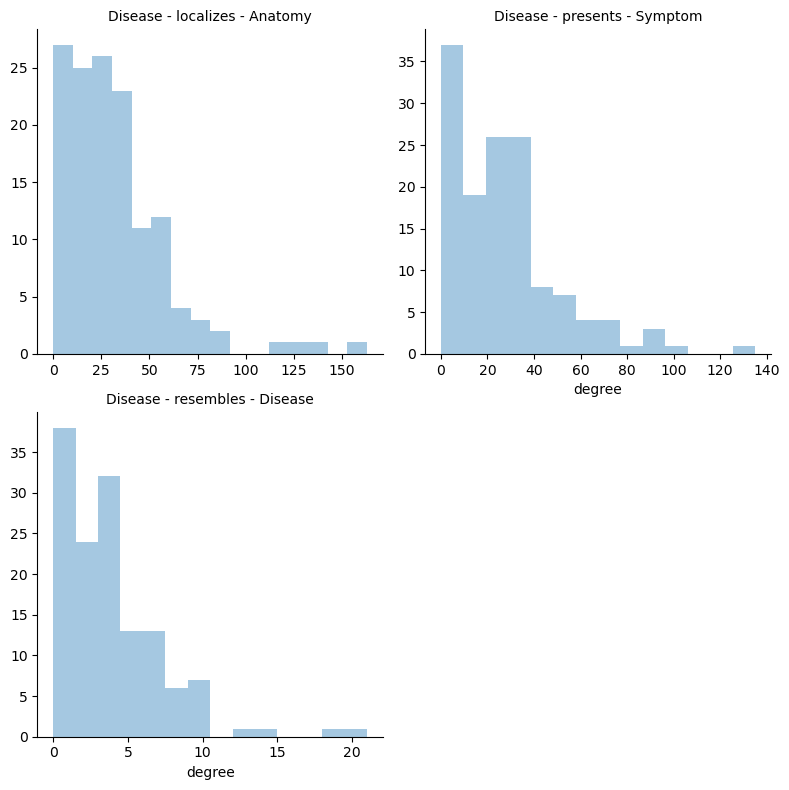

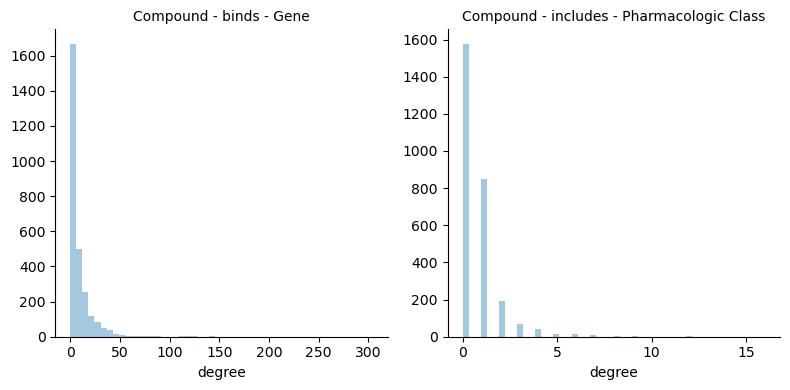

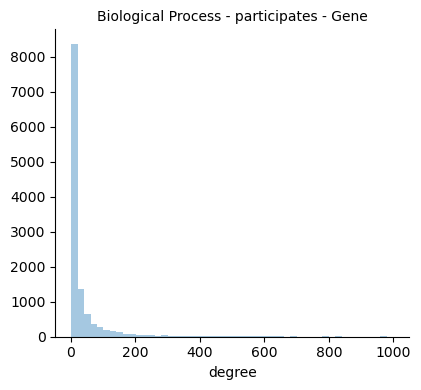

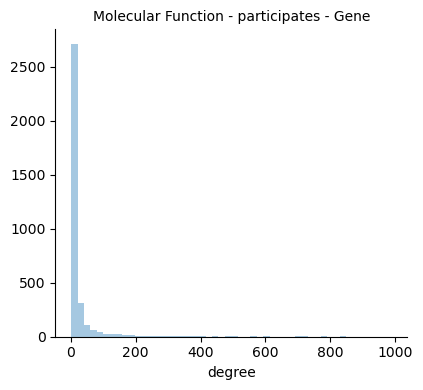

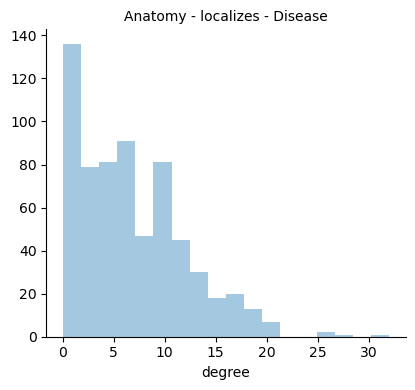

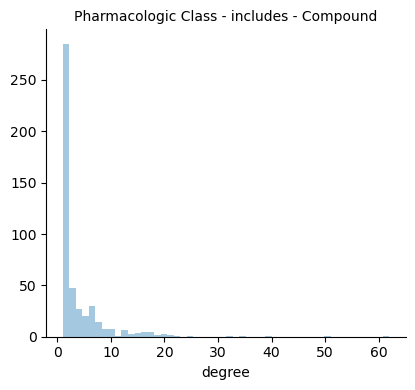

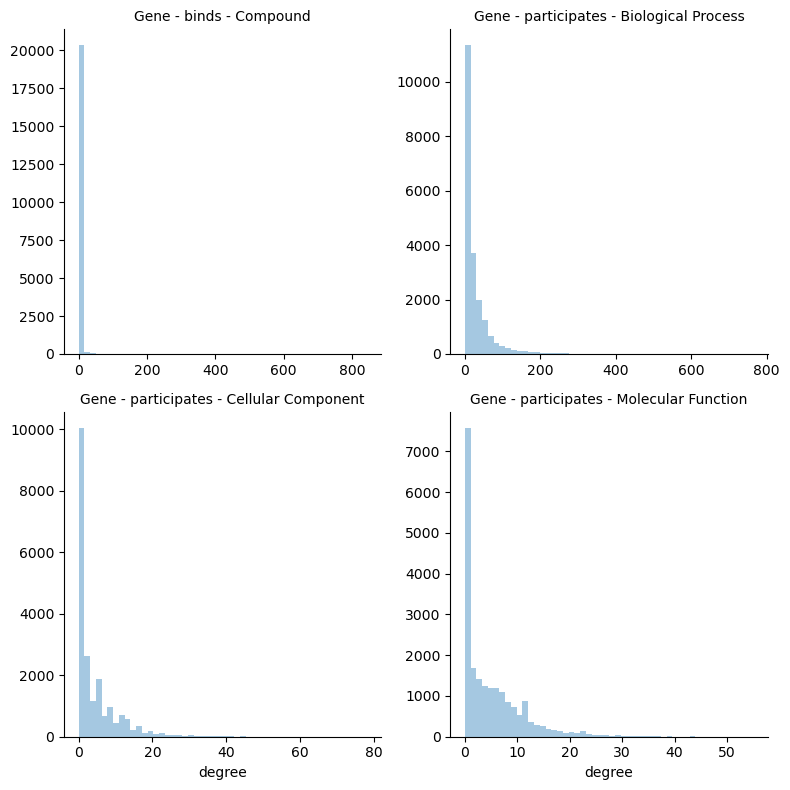

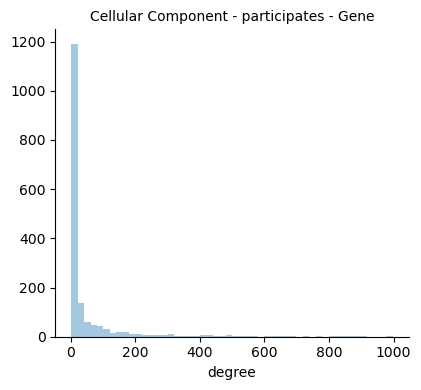

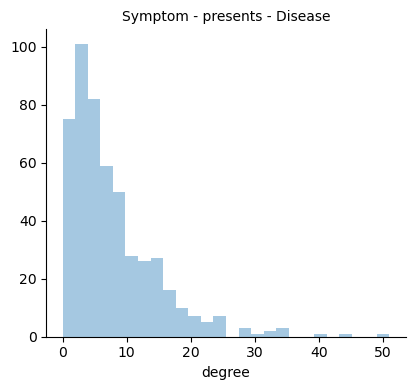

In [42]:
# Create and save degree distribution vizualizations
# Commented out due to https://github.com/ContinuumIO/anaconda-issues/issues/368
hetio.stats.plot_degrees(graph, os.path.join(path,'degrees.pdf'))

In [32]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetio.stats.get_metanode_df(graph)
metanode_df.to_csv(os.path.join(path,'metanodes.tsv'), sep='\t', index=False)
metanode_df

/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:80: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:80: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:80: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:80: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()


,metanode,abbreviation,metaedges,nodes,unconnected_nodes
3,Anatomy,A,1,652,115
6,Biological Process,BP,1,12322,0
8,Cellular Component,CC,1,1695,0
2,Compound,C,2,2778,535
1,Disease,D,3,137,16
0,Gene,G,4,20608,3232
7,Molecular Function,MF,1,3460,0
5,Pharmacologic Class,PC,1,478,0
4,Symptom,S,1,505,35


In [33]:
# Total number of nodes
metanode_df.nodes.sum()

42635

In [34]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetio.stats.get_metaedge_df(graph)

# Calculate number of unbiased edges
rows = list()
for metaedge, edges in graph.get_metaedge_to_edges(exclude_inverts=True).items():
    unbiased = sum(edge.data['unbiased'] for edge in edges)
    rows.append({'metaedge': str(metaedge), 'unbiased': unbiased})

metaedge_df = metaedge_df.merge(pandas.DataFrame(rows))
metaedge_df.to_csv(os.path.join(path,'metaedges.tsv'), sep='\t', index=False)
metaedge_df

/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:97: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:97: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:97: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:97: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()


,metaedge,abbreviation,edges,source_nodes,target_nodes,unbiased
0,Compound - binds - Gene,CbG,25733,2167,2705,0
1,Disease - localizes - Anatomy,DlA,4335,121,537,0
2,Disease - presents - Symptom,DpS,3758,121,470,0
3,Disease - resembles - Disease,DrD,250,87,81,0
4,Gene - participates - Biological Process,GpBP,548342,16061,12322,0
5,Gene - participates - Cellular Component,GpCC,88885,12241,1695,0
6,Gene - participates - Molecular Function,GpMF,104777,14213,3460,0
7,Pharmacologic Class - includes - Compound,PCiC,1948,478,1202,0


In [62]:
# Summary of different styles for representing each metaedge
#metaedge_style_df = hetio.stats.get_metaedge_style_df(metagraph)
#metaedge_style_df.to_csv('data/summary/metaedge-styles.tsv', sep='\t', index=False)

In [35]:
# Number of edges in the network
metaedge_df.edges.sum()

778028

## Save graph

In [36]:
import os
path ='../data'

In [37]:
# Write nodes to a table
hetio.readwrite.write_nodetable(graph, os.path.join(path,'nodes.tsv'))

# Write edges to a table
hetio.readwrite.write_sif(graph, os.path.join(path,'edges.sif.gz'))

## Barplots of metaedge and metanode counts

In [38]:
%matplotlib inline

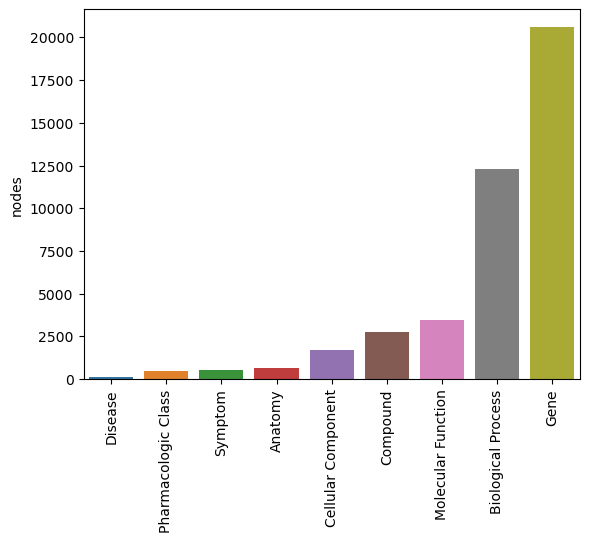

In [39]:
ax = seaborn.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

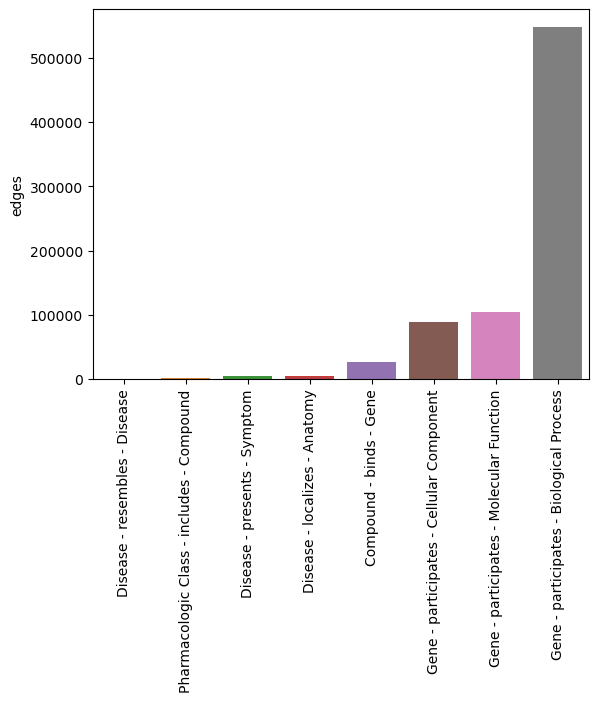

In [40]:
ax = seaborn.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');